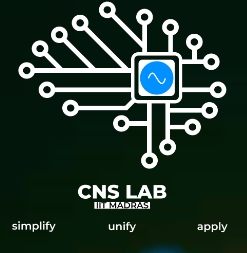
# CNSLM 2024
### Rhythms in the Brain - Workshop on Deep Oscillatory Neural Network Models




---



## Deep Oscillatory Neural Network

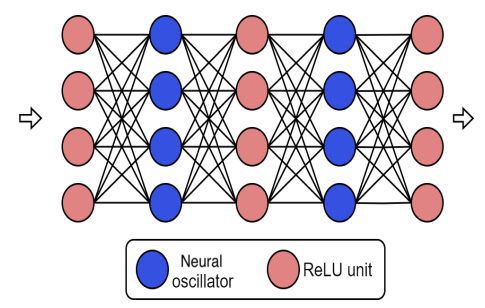

In [1]:
import math
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd

Task detail:

Input data: I(t) = $\Sigma_i sin(\omega_i t+\phi_i)$


Output data: Y(t) = $\Sigma_i sin((\omega_i + c) t+\phi_i)$

In [2]:
def generate_signals(num_samples=16, time_steps=1000,
                     num_components=1, min_omega=1,
                     max_omega=10, phase_delay=False,
                     c=0):

    t = np.arange(0, 1, 0.001)
    X = []
    Y = []
    for _ in range(num_samples):
        signal = np.zeros(time_steps)
        d_signal = np.zeros(time_steps)
        for _ in range(num_components):
            omega = np.random.randint(min_omega, max_omega)
            init_phase = 0
            if phase_delay:
                init_phase = np.random.rand()*2*np.pi
            signal += np.sin((2*np.pi)*(omega)*t + init_phase)
            d_signal += np.sin((2*np.pi)*(2*omega)*t + init_phase)
        X.append(signal)
        Y.append(d_signal)
    X = np.stack(X)
    Y = np.stack(Y)
    return np.expand_dims(X, -1), np.expand_dims(Y, -1)

a, b = generate_signals(num_samples=200,num_components=2,
                        c=5, min_omega=5, max_omega=10)
print(a.shape, b.shape)

(200, 1000, 1) (200, 1000, 1)


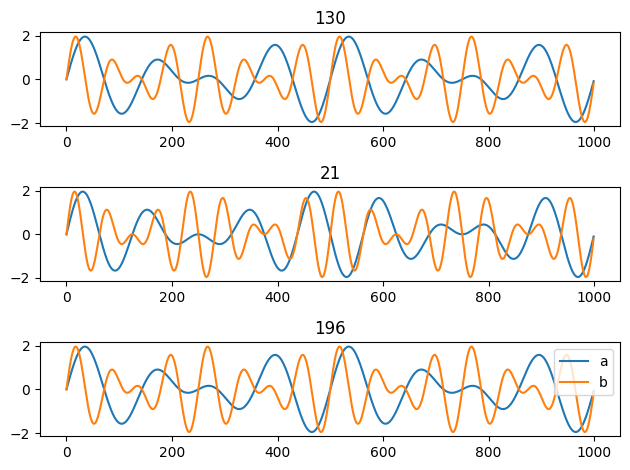

In [3]:
# @title
fig, axs = plt.subplots(3)
for i in range(3):
    tt = np.random.randint(0, 200)
    axs[i].plot(a[tt].reshape(-1), label='a')
    axs[i].plot(b[tt].reshape(-1), label='b')
    axs[i].set_title(str(tt))
plt.legend()
plt.tight_layout()
plt.show()

Subclassing from Tensorflow's `Layer` class

```python
class Subclass(ParentClass):                             
    def __init__(self, **kwargs):
        super(Subclass, self).__init__(**kwargs)
        # your definitions and variables
    
    def call(self, inputs):
        # do some operations that are differentiable
```

Oscillator layer

In [4]:
@tf.function
def oscillator_loop(X_r, X_i, omega_param, num_steps,
                    dt, input_scaler, beta1):
    """
    Loop to run Euler method on Hopf equations

    Args:
        X_r (Tensor): Input to real
        X_i (Tensor): Input to imaginary
        omega_param (Tensor): frequency values
        num_steps (int): time steps
        dt (int): step size
        input_scaler (float)
        beta1 (float)

    Returns:
        Tensor, Tensor: r and phi
    """
    r_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    phi_arr = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    omega_param = omega_param * (2*3.1415)
    r_t = tf.ones((X_r.shape[0], X_r.shape[-1]))
    phis = tf.zeros((X_r.shape[0], X_r.shape[-1]))
    for t in tf.range(num_steps):
        input_r = input_scaler*X_r[:,t,:]*tf.math.cos(phis)
        input_phi = input_scaler*X_i[:,t,:]*tf.math.sin(phis)
        r_t = r_t + ((1 - beta1*tf.square(r_t)) * r_t + input_r) * dt
        phis = phis + (omega_param - input_phi) * dt
        r_arr = r_arr.write(r_arr.size(), r_t)
        phi_arr = phi_arr.write(phi_arr.size(), phis)
    r_arr = tf.transpose(r_arr.stack(), [1, 0, 2])
    phi_arr = tf.transpose(phi_arr.stack(), [1, 0, 2])
    return r_arr, phi_arr

class Hopf(tf.keras.layers.Layer):

    def __init__(self, dim, num_steps, min_omega=0.1,
                 max_omega=10.1, train_omegas=False,
                 dt=0.001, input_scaler=5.0, beta1=1.0, **kwargs):
        """
        Hopf oscillator layer

        Args:
            dim (int): number of hopf units
            num_steps (int): no. of time steps in sequence
            min_omega (float, optional): minimum frequency (in Hz). Defaults to 0.1.
            max_omega (float, optional): minimum frequency (in Hz). Defaults to 10.1.
            train_omegas (bool, optional): whether to train omegas also. Defaults to False.
            dt (float, optional): step size. Defaults to 0.001.
            input_scaler (float, optional): multiplier of input to hopf. Defaults to 5.
            beta1 (float, optional): width of basin of attraction for resonance. Defaults to 1.
        """
        super(Hopf, self).__init__(**kwargs)

        self.dim = dim
        self.num_steps = num_steps
        self.min_omega = min_omega
        self.max_omega = max_omega
        self.train_omegas = train_omegas
        self.dt = dt
        self.input_scaler = input_scaler
        self.beta1 = beta1

        omega_init = tf.random.uniform((1, self.dim), -1, 1)
        self.omegas = tf.Variable(omega_init, trainable=train_omegas)

    def call(self, X_r, X_i):
        """
        Forward function

        Args:
            X_r (Tensor): Input to real
            X_i (Tensor): Input to imaginary

        Returns:
            Tensor, Tensor: real and complex output
        """
        omega_inp = self.omegas * (self.max_omega - self.min_omega) + self.min_omega
        r, phi = oscillator_loop(X_r, X_i, omega_inp, self.num_steps,
                                 self.dt, self.input_scaler, self.beta1)
        z_real = r * tf.math.cos(phi)
        z_imag = r * tf.math.sin(phi)
        return z_real, z_imag


Model class

In [8]:
duration = 1_000

class Model(tf.keras.Model):

    def __init__(self, units, **kwargs):

        super(Model, self).__init__(**kwargs)

        self.d1_r = tf.keras.layers.Dense(units,activation='relu')
        self.d1_i = tf.keras.layers.Dense(units,activation='relu')

        self.osc1 = Hopf(units, num_steps=duration, min_omega=0.1,
                         max_omega=12, train_omegas=True, dt=0.001)

        self.d2_r = tf.keras.layers.Dense(units,activation='relu')
        self.d2_i = tf.keras.layers.Dense(units,activation='relu')

        self.osc2 = Hopf(units, num_steps=duration, min_omega=0.1,
                         max_omega=12, train_omegas=True, dt=0.001)

        self.d = tf.keras.layers.Dense(units, activation='tanh')
        self.out_dense = tf.keras.layers.Dense(1)

    def call(self, X):

        out1_r = tf.keras.layers.TimeDistributed(self.d1_r)(X)
        out1_i = tf.keras.layers.TimeDistributed(self.d1_i)(X)

        z1_r, z1_i = self.osc1(out1_r, out1_i)

        z1_r = tf.keras.layers.TimeDistributed(self.d2_r)(z1_r)
        z1_i = tf.keras.layers.TimeDistributed(self.d2_i)(z1_i)

        z2_r, z2_i = self.osc2(z1_r, z1_i)

        concat_inp = tf.concat([z2_r, z2_i], 2)

        out2 = tf.keras.layers.TimeDistributed(self.d)(concat_inp)
        out_final = tf.keras.layers.TimeDistributed(self.out_dense)(out2)
        return out_final

model = Model(30)
optimizer = tf.keras.optimizers.Adam(0.01)

Train the model

In [ ]:
model.compile(optimizer, 'mse')
model.fit(a, b, epochs=500, batch_size=10, validation_split=0.2)

Test the model

In [ ]:
out = model.predict(a[0:4], batch_size=2)

2/2 [==============================] - 45s 41ms/step


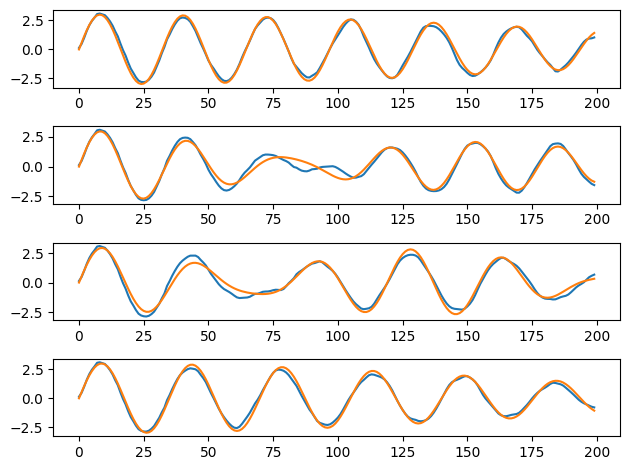

In [ ]:
fig, axs = plt.subplots(4)
for i in range(4):
    axs[i].plot(out[i].reshape(-1), label='predicted')
    axs[i].plot(b[i].reshape(-1), label='desired')
plt.tight_layout()
plt.show()

Neuroscience applications:
- Memory recall
- autonoetic memory



---



Yaksha: What is faster than wind?

Yudishtra: Mind

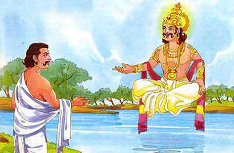